In [401]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import math

In [548]:
class Line:
    def __init__(self, rho, theta):
        self.rho = rho
        self.theta = theta
        
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a*self.rho
        y0 = b*self.rho
        self.x1 = int(x0 + 10000*(-b))
        self.y1 = int(y0 + 10000*(a))
        self.x2 = int(x0 - 10000*(-b))
        self.y2 = int(y0 - 10000*(a))
        
        self.slope = (self.y2-self.y1)/(self.x2-self.x1)
    
    def __str__(self):
        return "{} {}".format(self.rho, self.theta)
    def __repr__(self):
        return "{} {}".format(self.rho, self.theta)
    
    def intersection(self, other_line):
        line1 = [[self.x1, self.y1] , [self.x2, self.y2]]
        line2 = [[other_line.x1, other_line.y1] , [other_line.x2, other_line.y2]]
        xdiff = (line1[0][0] - line1[1][0], line2[0][0] - line2[1][0])
        ydiff = (line1[0][1] - line1[1][1], line2[0][1] - line2[1][1])

        def det(a, b):
            return a[0] * b[1] - a[1] * b[0]

        div = det(xdiff, ydiff)
        if div == 0:
#             raise Exception('lines do not intersect')
            return 10000000,1000000

        d = (det(*line1), det(*line2))
        x = det(d, xdiff) / div
        y = det(d, ydiff) / div
        return x, y
    
    def angleBetweenLines(self, other_line):
        m1 = self.slope
        m2 = other_line.slope
        angle = math.degrees(math.atan((m2-m1)/(1+m2*m1)))
#         print(angle)
        return angle


In [12]:
def resize(frame, scale):
    return cv.resize(frame, (int(scale*frame.shape[1]), int(scale*frame.shape[0])))

In [97]:
def skeleton(img_):
    img = img_.copy()
    size = np.size(img)
    skel = np.zeros(img.shape,np.uint8)

    element = cv2.getStructuringElement(cv2.MORPH_CROSS,(3,3))
    done = False

    while( not done):
        eroded = cv2.erode(img,element)
        temp = cv2.dilate(eroded,element)
        temp = cv2.subtract(img,temp)
        skel = cv2.bitwise_or(skel,temp)
        img = eroded.copy()

        zeros = size - cv2.countNonZero(img)
        if zeros==size:
            done = True
    return skel
    

In [304]:
def regressionLineForPixels(skel_img, linep1, linep2):
    linep1 = np.array(linep1)
    linep2 = np.array(linep2)
    skel_img = skel_img.copy()
    
    close_pixels = []
    
    row,col = np.where(skel_img==255)
    white_pixels = np.concatenate((col.reshape(len(col),1), row.reshape(len(row),1)), 1)
    
    for pixel in white_pixels:
        d = np.linalg.norm(np.cross(linep2-linep1, linep1-pixel))/np.linalg.norm(linep2-linep1)
        if d < 15:
            close_pixels.append([pixel[0], pixel[1]])
            skel_img[pixel[1], pixel[0]] = 0
    
    close_pixels_a = np.array(close_pixels)
    
    reg = LinearRegression().fit(close_pixels_a[:,0].reshape(-1, 1), close_pixels_a[:,1].reshape(-1, 1))
    coef = reg.coef_
    interecept = reg.intercept_
    
    x_min = np.min(close_pixels_a[:,0])
    x_max = np.max(close_pixels_a[:,0])
    return skel_img, (x_min, reg.predict([[x_min]])), (x_max, reg.predict([[x_max]]))
        

In [397]:
def regressionLinesForPixels(skel_img, line_points):
#     returns an array of start and end points for lines
    top_pixel = np.min(np.where(img_adpThresh==255)[0])
    return_a = []
    print(top_pixel)
    skel_img = skel_img.copy()
#     lines_points should be n * 2 (points) * 2 (x and y)
    for line in line_points:
        linep1 = line[0]
        linep2 = line[1]

        line_img = np.zeros_like(skel_img)
        cv.line(line_img,tuple(linep1),tuple(linep2),(255),1)
        
        close_pixels = []
        
        min_dilation = 12
        max_dilation = 80
        
        step = int((skel_img.shape[0]-top_pixel+10)/(max_dilation-min_dilation))
        
        kernel_small = np.ones((2,2), np.uint8)
        line_img = cv.dilate(line_img, kernel_small,iterations=min_dilation)
        for i in range(max_dilation-min_dilation):
#             kernel = np.ones((min_dilation+i,min_dilation+i), np.uint(8))
#             line_img[top_pixel+i*step : top_pixel+(i+1)*step, : ] = cv.dilate(line_img[top_pixel+i*step : top_pixel+(i+1)*step, : ], kernel, iterations=1)
            line_img[top_pixel+i*step : , : ] = cv.dilate(line_img[top_pixel+i*step : , : ], kernel_small, iterations=1)
            
    
#         line_img = cv.dilate(line_img,np.ones((min_dilation,min_dilation), np.uint(8)))
        
#         plt.figure(figsize=(18,16))
#         plt.imshow(line_img)
        idx_skel_img = (skel_img==255)
        idx_line_img = (line_img==255)
        idx_close_pixels = np.logical_and(idx_line_img, idx_skel_img)
        row,col = np.where(idx_close_pixels)
        white_pixels = np.concatenate((col.reshape(len(col),1), row.reshape(len(row),1)), 1)
        for pixel in white_pixels:
            close_pixels.append([pixel[0], pixel[1]])

#         row,col = np.where(skel_img==255)
#         white_pixels = np.concatenate((col.reshape(len(col),1), row.reshape(len(row),1)), 1)       
#         for pixel in white_pixels:
#             d = np.linalg.norm(np.cross(linep2-linep1, linep1-pixel))/np.linalg.norm(linep2-linep1)
#             if d < 25:
#                 close_pixels.append([pixel[0], pixel[1]])

#         only add line to returning array and remove pixels from img if the line isn't a duplicate
        if len(close_pixels) > 1000:
            for pixel in close_pixels:
                skel_img[pixel[1], pixel[0]] = 0

            close_pixels_a = np.array(close_pixels)

            reg = LinearRegression().fit(close_pixels_a[:,0].reshape(-1, 1), close_pixels_a[:,1].reshape(-1, 1))
            coef = reg.coef_
            interecept = reg.intercept_

            x_min = np.min(close_pixels_a[:,0])
            x_max = np.max(close_pixels_a[:,0])
            
            return_a.append([[x_min, reg.predict([[x_min]])], [x_max, reg.predict([[x_max]])]])
        
    
    return skel_img, np.array(return_a)


In [546]:
def middleLines(skel_img, lines):
    
    top_pixel = np.min(np.where(img_adpThresh==255)[0])
    line_clusters = []
    return_a = []
#     print("top pixel ", top_pixel)
#     print("shape ", skel_img.shape)
    
    
    count = 0
    for line in lines:
        is_added = False
#         print(count, "#: " ,line)
        count+=1
        for line_cluster in line_clusters:
#             print("checking with cluster: ", line_cluster)
            for other_line in line_cluster:
                x,y = line.intersection(other_line)
#                 print("intersection: ",x , " ",y)
#                 print(x < skel_img.shape[1])
                if x>0 and x < skel_img.shape[1] and y > top_pixel and y < skel_img.shape[0] and abs(line.angleBetweenLines(other_line)) < 5:
                    line_cluster.append(line)
                    is_added = True
                    break
            if is_added:
                break
        if not is_added:
            line_clusters.append([line])
#             print("making new cluster")
            
            
#     print("Line clusters", line_clusters)
    for line_cluster in line_clusters:
        cur_cluster = []
        for line in line_cluster:
            cur_cluster.append([line.rho, line.theta])
        mean = np.mean(np.array(cur_cluster),axis=0)
        
        
        return_a.append(Line(mean[0], mean[1]))
#     print("return array", return_a)
    return return_a

In [561]:
# LINES METHODS

def isNetOnLeft(lines):
#     returns whether the net is on the left
    positive_count = 0
    negative_count = 0
    for line in lines:
#         print(line.slope)
        if line.slope>0:
            positive_count+=1
        else:
            negative_count+=1
    return positive_count<negative_count

In [549]:
lines = Line(489.0, 1.7584192752838135), Line(486.0, 1.7409658432006836), Line(481.0, 1.7453292608261108)
middleLines(img_adpThresh, lines)


[489.0 1.7584192752838135, 483.5 1.7431475520133972]

In [286]:
PLACES = ["SBCC","LB","NP"]
NUM = 1
imgs_bgr = []
imgs_rgb = []
imgs_hsv = []
imgs_gray= []
imgs_min = []

for i in range(len(PLACES)):
    imgs_bgr.append(cv.imread("picture_{}_{}.JPG".format(PLACES[i], NUM)))
    imgs_rgb.append(cv.cvtColor(imgs_bgr[i], cv.COLOR_BGR2RGB))
    imgs_hsv.append(cv.cvtColor(imgs_bgr[i], cv.COLOR_BGR2HSV))
    imgs_gray.append(cv.cvtColor(imgs_bgr[i], cv.COLOR_BGR2GRAY))
    imgs_min.append(np.min(imgs_rgb[i],2).astype(np.uint8))
#     plt.figure(figsize=(18, 16))
#     plt.imshow(imgs_rgb[i])

-0.2914583333333333
-0.19978583448064863
0.1280435549730302
0.05674362698452447
-0.06549408699138104
-0.10066338325459845
True


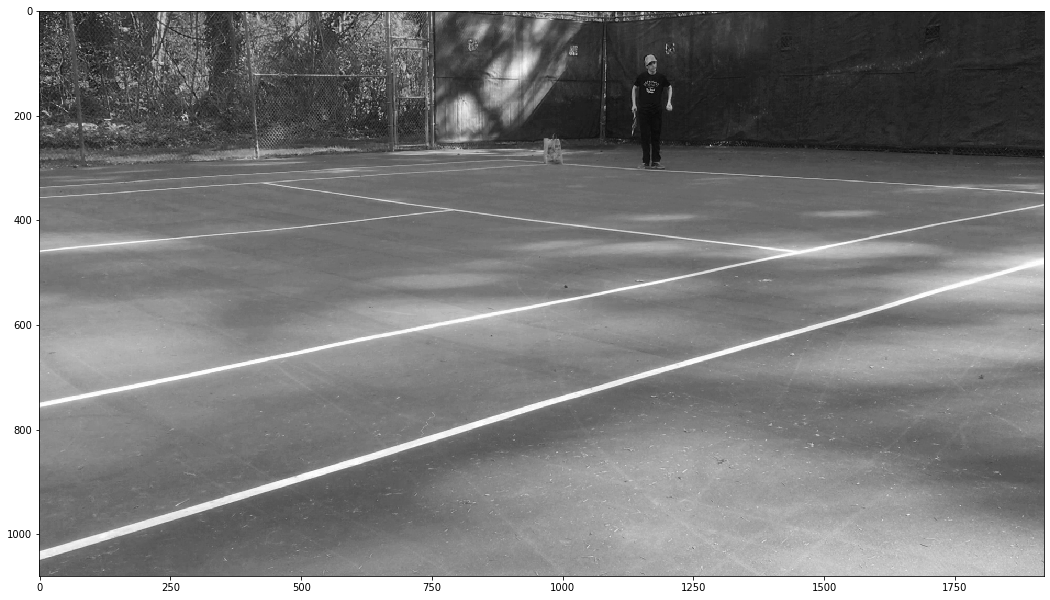

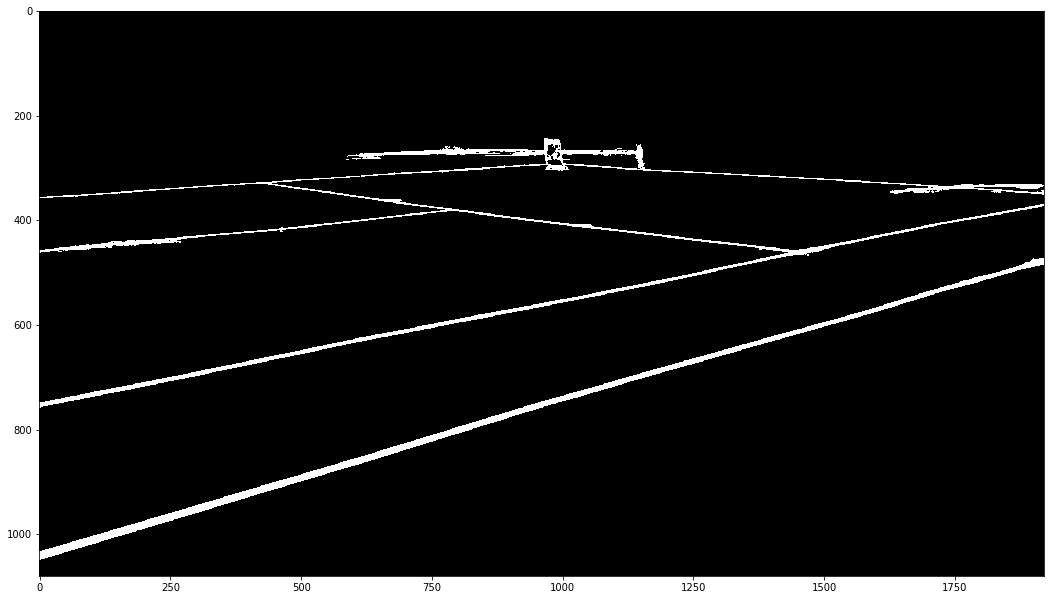

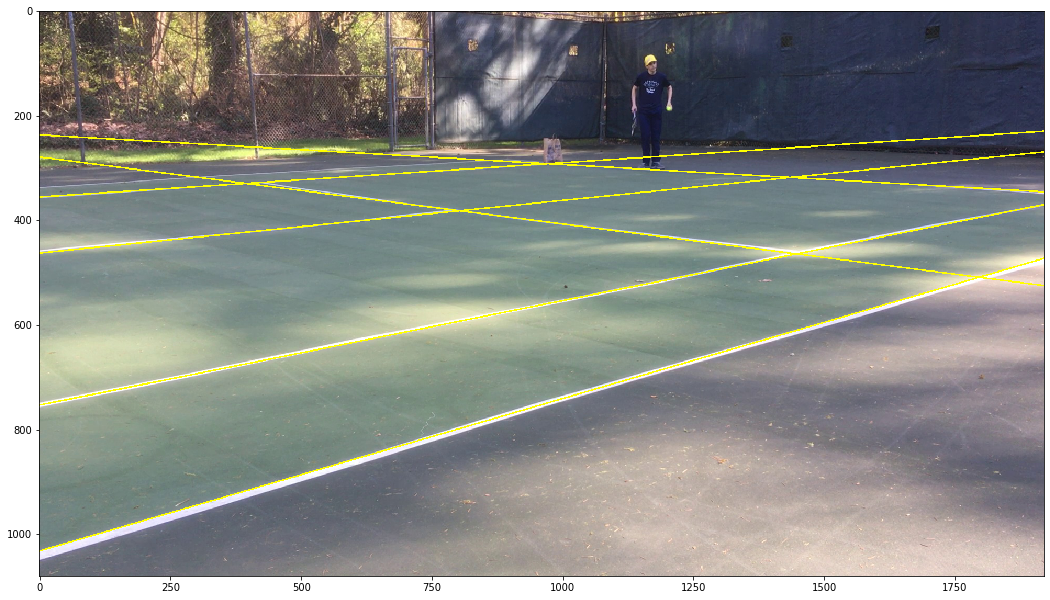

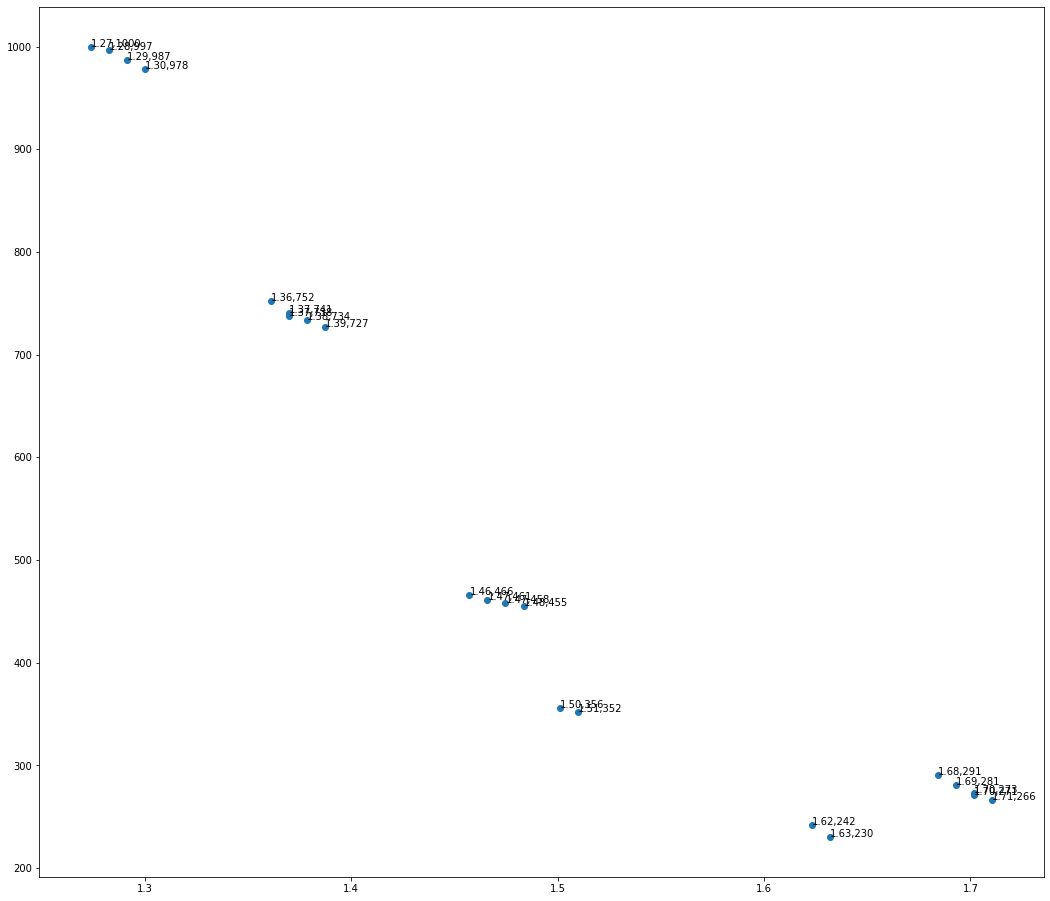

-0.13518013926733272
0.2678848742105808
0.18979030944625408
-0.048057669203043656
0.17330626744481095
False


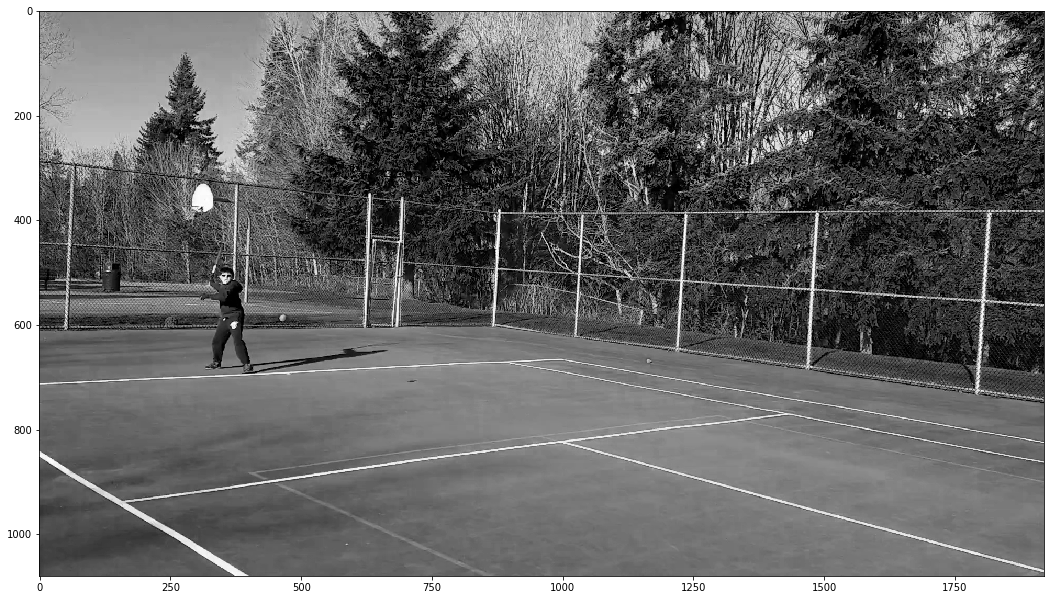

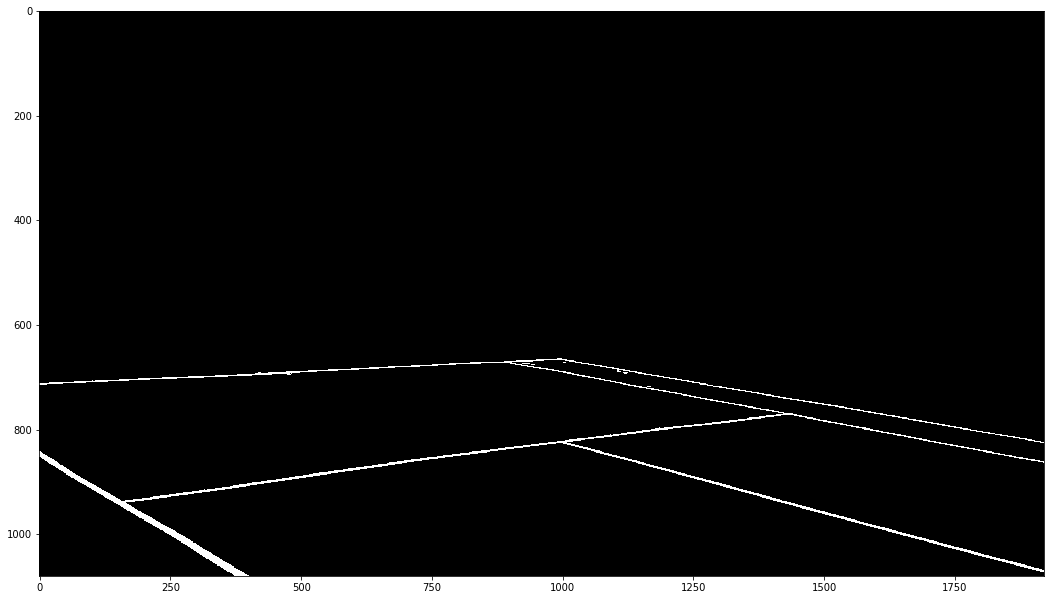

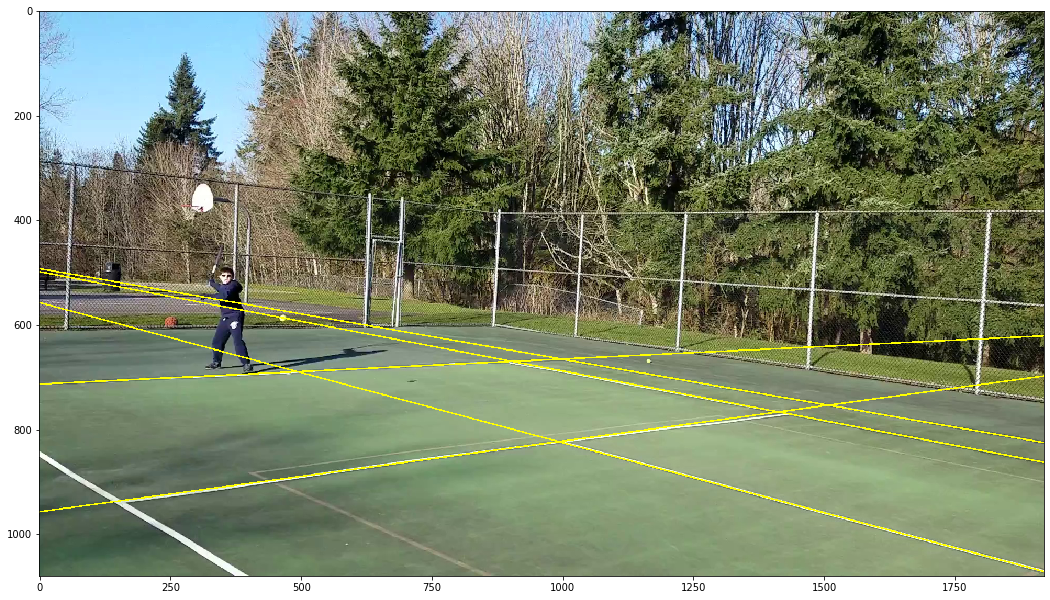

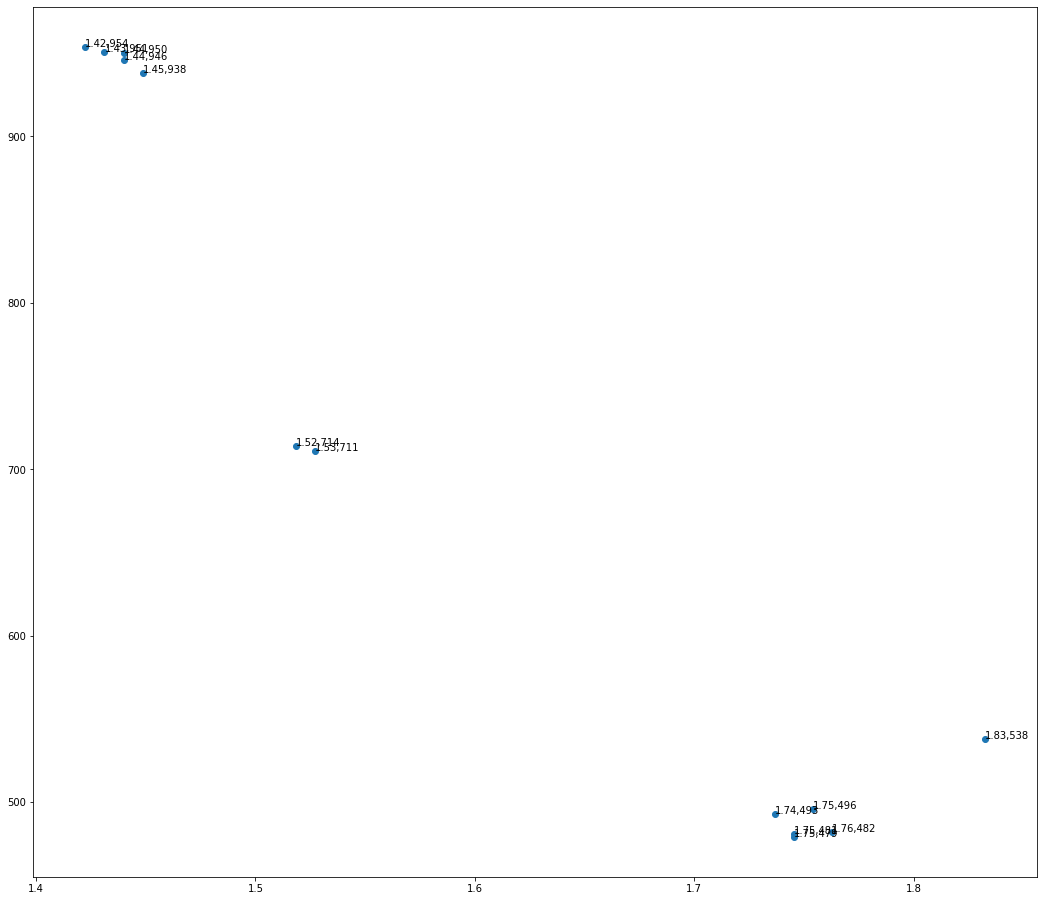

0.07869789837989667
-0.5317136708574017
0.11832829808660625
-0.15835569280615602
-0.08744101997791387
-0.33942338156088286
-0.10065832453892155
True


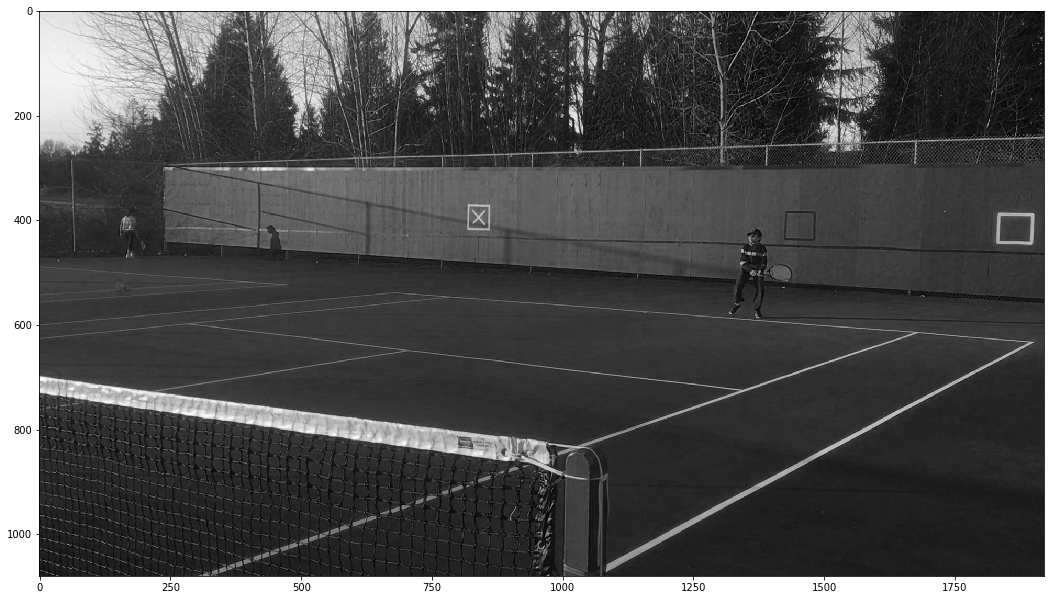

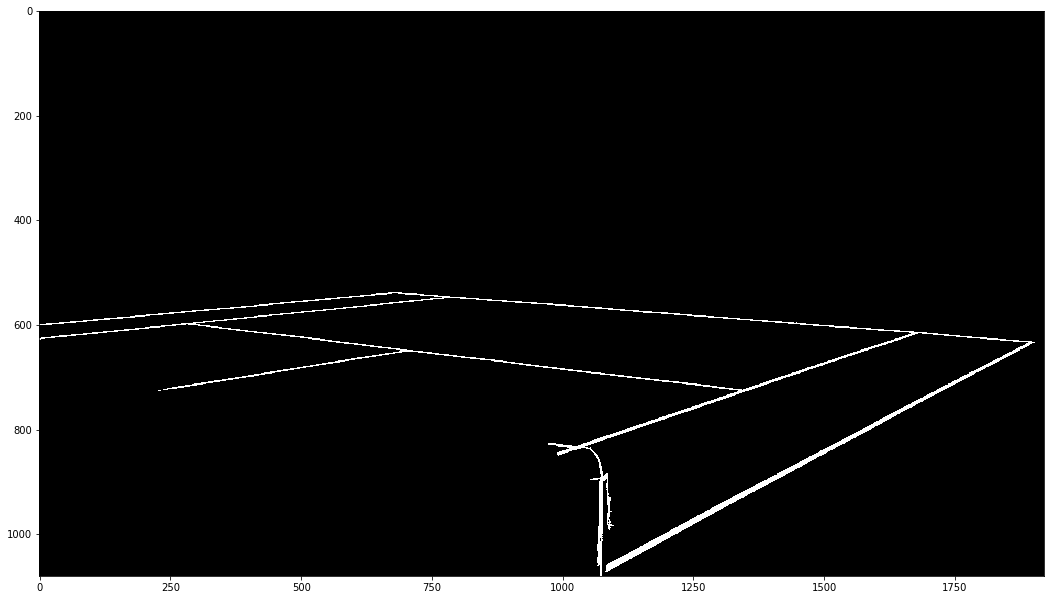

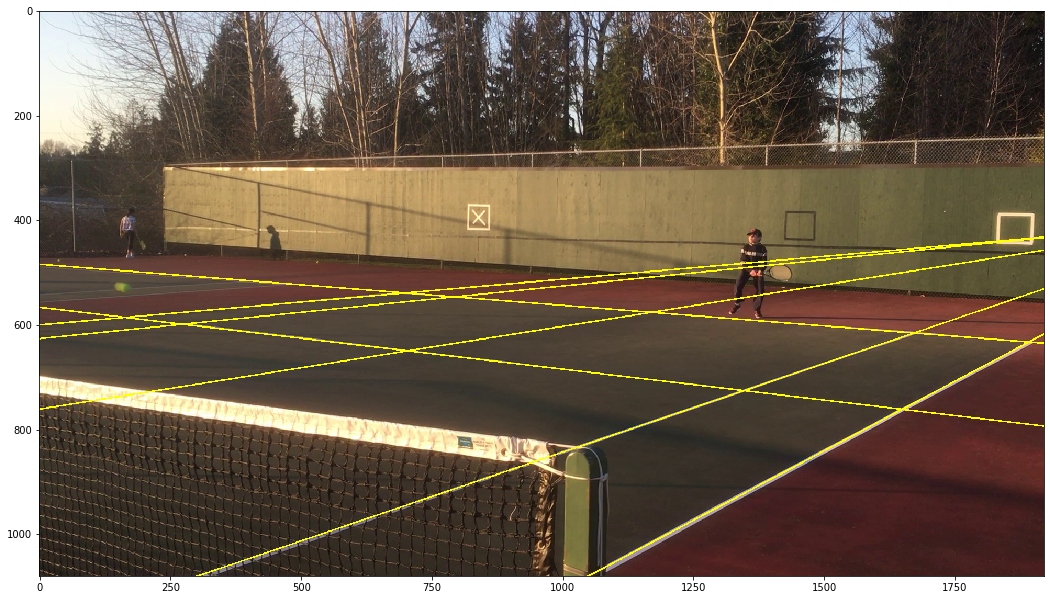

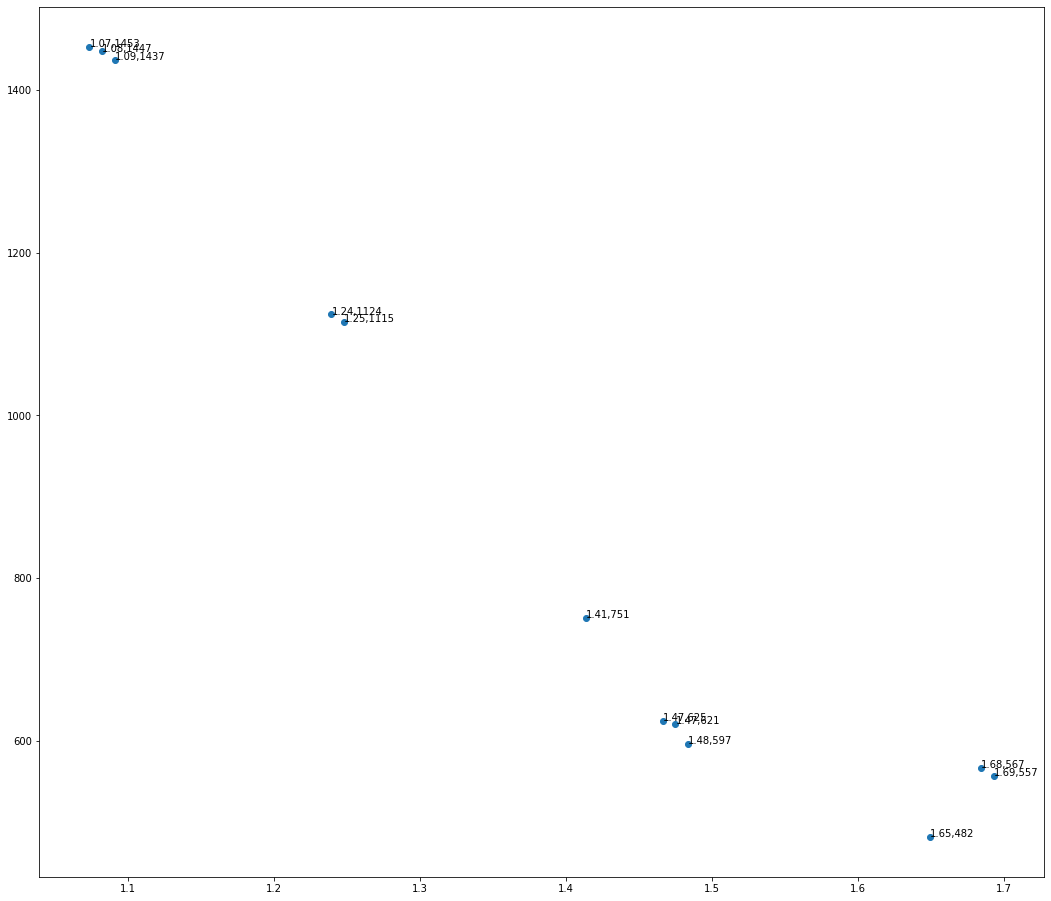

In [560]:
for i in range(len(PLACES)):
#     plt.figure(figsize=(18, 16))
#     plt.plot(imgs_min[i][600])
    
    
    img_adpThresh = cv.adaptiveThreshold(imgs_min[i], 255, cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY, 25, -2)
    kernel = np.ones((3,3),np.uint8)
    img_adpOpen = cv.morphologyEx(img_adpThresh, cv.MORPH_OPEN, kernel)
#     edges = cv.Canny(img_adpOpen, threshold1=100, threshold2=200, apertureSize=3)
    
    num_labels, labels, stats, centroids = cv.connectedComponentsWithStats(img_adpThresh , 8 , cv.CV_32S)
#     print(stats[[np.logical_and(stats[:,cv.CC_STAT_WIDTH]>1500, stats[:,cv.CC_STAT_TOP]>200)]])
    label_lines = np.where([np.logical_and(stats[:,cv.CC_STAT_WIDTH]>1500, stats[:,cv.CC_STAT_TOP]>200)])[1]
    idx_lines = (labels!=label_lines[0])
    for j in label_lines:
        idx_lines = np.logical_and(idx_lines, labels!=j)
    img_adpThresh[idx_lines]=0
    img_adpThresh[img_adpThresh>0]=255
    
    kernel = np.ones((3,3),np.uint8)
    erosion = cv2.erode(img_adpThresh,kernel,iterations = 1)
    
    skel = skeleton(img_adpThresh)
    
#     skel = cv.flip(skel,0)
    lines = cv.HoughLines(skel,1,np.pi/360,250)
#     img_rgb = cv.flip(imgs_rgb[i],0)

    line_points = []
    lines_classLines = []
    
    img_rgb = imgs_rgb[i].copy()
    for rho,theta in lines[:,0]:
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a*rho
        y0 = b*rho
        x1 = int(x0 + 10000*(-b))
        y1 = int(y0 + 10000*(a))
        x2 = int(x0 - 10000*(-b))
        y2 = int(y0 - 10000*(a))
        
        lines_classLines.append(Line(rho, theta))
        
        line_points.append([[x1,y1],[x2,y2]])

#         cv.line(img_rgb,(x1,y1),(x2,y2),(0,0,255),2)

#      for a single line
#     skel_img2, p1, p2  = regressionLineForPixels(img_adpThresh, (x1,y1),(x2,y2))
#     cv.line(img_rgb,p1,p2,(255,0,0),2)

#     for all lines
    
#     _, line_points_new = regressionLinesForPixels(img_adpThresh, np.array(line_points))
#     for line in line_points_new:
#         cv.line(img_rgb,tuple(line[0]),tuple(line[1]),(255,0,0),2)
    
    lines_new = middleLines(img_adpThresh, lines_classLines)
    for line in lines_new:
        cv.line(img_rgb,(line.x1, line.y1),(line.x2, line.y2),(255,255,0),2)
    
    is_net_on_left = isNetOnLeft(lines_new)
    
    
    
    plt.figure(figsize=(18, 16))
    plt.imshow(imgs_min[i], cmap = "gray")
    plt.figure(figsize=(18, 16))
    plt.imshow(img_adpThresh, cmap='gray')
#     plt.figure(figsize=(18, 16))
#     plt.imshow(edges, cmap='gray')
    plt.figure(figsize=(18, 16))
    plt.imshow(img_rgb)
    
    plt.figure(figsize=(18, 16))
    plt.scatter(lines[:,0,1], lines[:,0,0])
    for rho,theta in lines[:,0]:
        label = "{:.2f},{}".format(theta,int(rho))
        plt.annotate(label, (theta,int(rho)))
    plt.show()
    

In [ ]:
h, xedges, yedges, image = plt.hist2d(lines[:,0,1], lines[:,0,0], bins=7)
plt.show()
print(xedges)

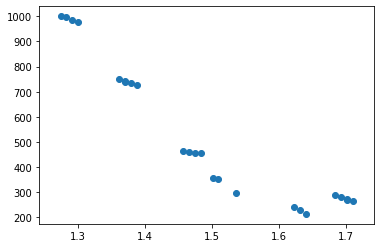

In [133]:
plt.scatter(lines[:,0,1], lines[:,0,0])
plt.show()

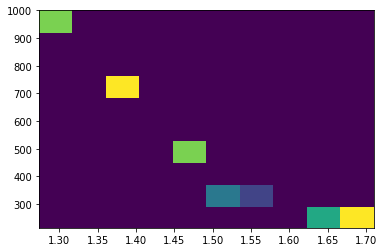

In [131]:
h, xedges, yedges, image = plt.hist2d(lines[:,0,1], lines[:,0,0],bins=10)
plt.show()

In [ ]:
# idx_hue_bright = np.logical_and((img_hsv[:,:,0]>=20), (img_hsv[:,:,0]<=45))
idx_sat_bright = np.logical_and((img_hsv[:,:,1]>=0), (img_hsv[:,:,1]<=40))
idx_val_bright = (img_hsv[:,:,2]>=170)
idx_hsv_bright = np.logical_and(idx_sat_bright, idx_val_bright)
img_rgb[idx_hsv_bright] = [0,0,0]
plt.imshow(img_rgb)

In [ ]:
center1row = 550
center1col = 750

center2row = 20
center2col = 30

img_zoomed = img_rgb[center1row-25:center1row+25,center1col-25:center1col+25,:]
img_zoomed_hsv = cv.cvtColor(img_zoomed, cv.COLOR_RGB2HSV)

print(img_zoomed_hsv[center2row-2:center2row+2,center2col-2:center2col+2,:])

plt.imshow(img_zoomed)
plt.figure()
plt.imshow(img_zoomed[center2row-2:center2row+2,center2col-2:center2col+2,:])


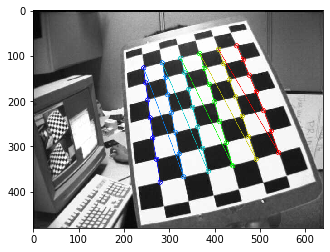

In [16]:
import numpy as np
import cv2
import glob

# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*7,3), np.float32)
objp[:,:2] = np.mgrid[0:7,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.

images = glob.glob('*.jpg')

for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chess board corners
    ret, corners = cv2.findChessboardCorners(gray, (7,6),None)

    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)

        corners2 = cv2.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)
        imgpoints.append(corners2)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (7,6), corners2,ret)
        plt.imshow(img)



In [19]:
objp

array([[0., 0., 0.],
       [1., 0., 0.],
       [2., 0., 0.],
       [3., 0., 0.],
       [4., 0., 0.],
       [5., 0., 0.],
       [6., 0., 0.],
       [0., 1., 0.],
       [1., 1., 0.],
       [2., 1., 0.],
       [3., 1., 0.],
       [4., 1., 0.],
       [5., 1., 0.],
       [6., 1., 0.],
       [0., 2., 0.],
       [1., 2., 0.],
       [2., 2., 0.],
       [3., 2., 0.],
       [4., 2., 0.],
       [5., 2., 0.],
       [6., 2., 0.],
       [0., 3., 0.],
       [1., 3., 0.],
       [2., 3., 0.],
       [3., 3., 0.],
       [4., 3., 0.],
       [5., 3., 0.],
       [6., 3., 0.],
       [0., 4., 0.],
       [1., 4., 0.],
       [2., 4., 0.],
       [3., 4., 0.],
       [4., 4., 0.],
       [5., 4., 0.],
       [6., 4., 0.],
       [0., 5., 0.],
       [1., 5., 0.],
       [2., 5., 0.],
       [3., 5., 0.],
       [4., 5., 0.],
       [5., 5., 0.],
       [6., 5., 0.]], dtype=float32)

In [ ]:
def mouse_drawing(event, x, y, flags, params):

    if event == cv.EVENT_LBUTTONDOWN:
        print(x*2,y*2)
        circles.append((x,y))
        

cv.namedWindow("Frame", flags=cv.WINDOW_NORMAL)
cv.setMouseCallback("Frame", mouse_drawing)
circles = []
while True:
    frame = resize(imgs_bgr[2], 0.5)
    for center_position in circles:
        cv.circle(frame, center_position, 2, (0, 0, 255), -1)
    cv.imshow("Frame", frame)
#     cv.resizeWindow("Frame", 960, 540)
    
    
    key = cv.waitKey(1)
    if key == 27:
        break
    elif key & 0xFF == ord('q'):
        circles = []
cap.release()
cv.destroyAllWindows()


In [ ]:
"""
base right corner 1898 632
base 2nd right corner 1676 610
base 2nd left corner 778 544
base left corner 682 534
service right 1642 764
service 2nd right 1342 726
service middle 698 646
service 2nd left 290 596
service left 196 582
"""
